# Fire AI - ML based Coverage Classifier

Author: Yuji Fujinami

Support: Bob YX Lee

### Import Libraries

In [3]:
import json
import logging 
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
from scipy.spatial import ConvexHull
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from typing_extensions import Annotated
from typing import Tuple, Union 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
from abc import ABC, abstractmethod

### Load Dataset

In [4]:
file_path = 'data/dataset.json'
df = pd.read_json(file_path)
print(df.head())

  date_generated                                               data
0     2024-03-24  {'id': '78a81cb9-e87e-4799-90fb-ef7d2a92be8f',...
1     2024-03-24  {'id': '55403f4e-9722-42b7-bed3-11d18514e012',...
2     2024-03-24  {'id': '9c611343-eeb9-4804-b7ac-c6a54931c73d',...
3     2024-03-24  {'id': '4891427b-0339-4405-b51d-e7d53dbb0e21',...
4     2024-03-24  {'id': '31ff0ffb-c94b-4dd5-9e67-cb8c590d5c6d',...


In [5]:
# Deconstruct data column into separate dataframe 
df = pd.json_normalize(df['data'])
print(df.head())

                                     id  \
0  78a81cb9-e87e-4799-90fb-ef7d2a92be8f   
1  55403f4e-9722-42b7-bed3-11d18514e012   
2  9c611343-eeb9-4804-b7ac-c6a54931c73d   
3  4891427b-0339-4405-b51d-e7d53dbb0e21   
4  31ff0ffb-c94b-4dd5-9e67-cb8c590d5c6d   

                                                room  \
0  [[0, 0], [9357, 0], [9357, 6552], [6738, 6552]...   
1  [[0, 10034], [0, 0], [7067, 0], [7067, 1351], ...   
2  [[7492, 0], [7492, 3334], [8615, 3334], [8615,...   
3  [[9428, 0], [9428, 5241], [9233, 5241], [9233,...   
4  [[9643, 0], [9643, 6587], [8624, 6587], [8624,...   

                                       extinguishers  comply  
0                                [[8702.25, 6552.0]]       1  
1  [[12991.416666666668, 1351.0], [5249.0, 7140.8...       1  
2  [[5886.571428571428, 0.0], [0.0, 4564.8], [695...       1  
3  [[2713.75, 8226.0], [0.0, 3598.875], [1628.25,...       1  
4  [[3750.055555555555, 0.0], [0.0, 5952.57142857...       1  


### Feature Engineering

In [8]:
# Calculate room area 
def calculate_area(coords):
    return Polygon(coords).area

# Calculate distances between extinguisher positions and room centroid 
def calculate_distances_to_center(room_coords, ext_coords):
    room_center = np.mean(room_coords, axis = 0)
    distances = euclidean_distances(ext_coords, [room_center]).flatten()
    return np.min(distances), np.max(distances), np.mean(distances)

# Calculate room perimeter
def calculate_perimeter(coords):
    return Polygon(coords).length

# Calculate variability of distances from all extinguishers to room centroid
def calculate_std_dev_distances_to_center(room_coords, ext_coords):
    _, _, mean_distance = calculate_distances_to_center(room_coords, ext_coords)
    distances = euclidean_distances(ext_coords, [np.mean(room_coords, axis=0)]).flatten()
    std_dev = np.std(distances)
    return std_dev

# Calculate distances between extinguisher positions and room vertices 
def vertex_to_extinguisher_distances(room_coords, ext_coords):
    distances = euclidean_distances(room_coords, ext_coords).flatten()
    return np.min(distances), np.max(distances), np.mean(distances)

# New features
new_features = df.apply(lambda row: pd.Series({
    'room_area': calculate_area(np.array(row['room'])),
    'ext_count': len(row['extinguishers']),
    'min_dist_to_center': calculate_distances_to_center(np.array(row['room']), np.array(row['extinguishers']))[0],
    'max_dist_to_center': calculate_distances_to_center(np.array(row['room']), np.array(row['extinguishers']))[1],
    'avg_dist_to_center': calculate_distances_to_center(np.array(row['room']), np.array(row['extinguishers']))[2],
    'room_perimeter': calculate_perimeter(np.array(row['room'])),
    'std_dev_dist_to_center': calculate_std_dev_distances_to_center(np.array(row['room']), np.array(row['extinguishers'])),
    # Additional new features 
    'vertex_min_dist_to_ext': vertex_to_extinguisher_distances(np.array(row['room']), np.array(row['extinguishers']))[0],
    'vertex_max_dist_to_ext': vertex_to_extinguisher_distances(np.array(row['room']), np.array(row['extinguishers']))[1],
    'vertex_avg_dist_to_ext': vertex_to_extinguisher_distances(np.array(row['room']), np.array(row['extinguishers']))[2],
}), axis=1)

df = pd.concat([df, new_features], axis=1)

print(df.head())

                                     id  \
0  78a81cb9-e87e-4799-90fb-ef7d2a92be8f   
1  55403f4e-9722-42b7-bed3-11d18514e012   
2  9c611343-eeb9-4804-b7ac-c6a54931c73d   
3  4891427b-0339-4405-b51d-e7d53dbb0e21   
4  31ff0ffb-c94b-4dd5-9e67-cb8c590d5c6d   

                                                room  \
0  [[0, 0], [9357, 0], [9357, 6552], [6738, 6552]...   
1  [[0, 10034], [0, 0], [7067, 0], [7067, 1351], ...   
2  [[7492, 0], [7492, 3334], [8615, 3334], [8615,...   
3  [[9428, 0], [9428, 5241], [9233, 5241], [9233,...   
4  [[9643, 0], [9643, 6587], [8624, 6587], [8624,...   

                                       extinguishers  comply    room_area  \
0                                [[8702.25, 6552.0]]       1  110828184.0   
1  [[12991.416666666668, 1351.0], [5249.0, 7140.8...       1   99333856.0   
2  [[5886.571428571428, 0.0], [0.0, 4564.8], [695...       1   83646478.0   
3  [[2713.75, 8226.0], [0.0, 3598.875], [1628.25,...       1   75884535.0   
4  [[3750.055555555

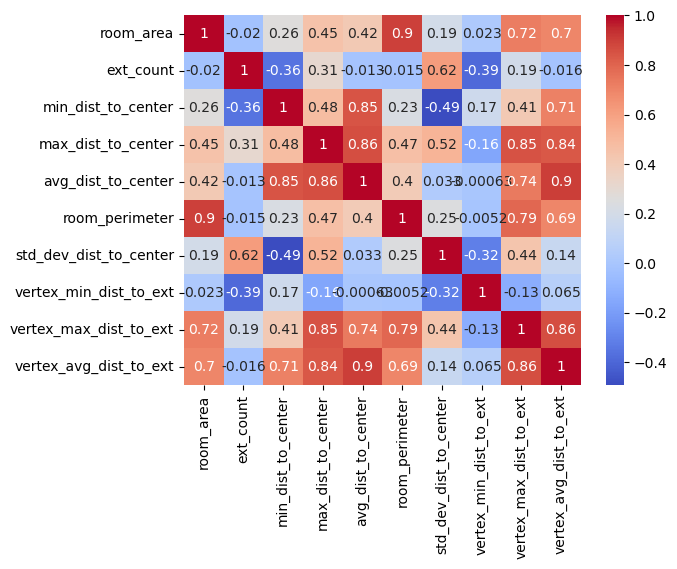

,room_area,ext_count,min_dist_to_center,max_dist_to_center,avg_dist_to_center,room_perimeter,std_dev_dist_to_center,vertex_min_dist_to_ext,vertex_max_dist_to_ext,vertex_avg_dist_to_ext
room_area,1.000000,-0.020334,0.264929,0.450412,0.415516,0.897644,0.192416,0.022645,0.722095,0.696802
ext_count,-0.020334,1.000000,-0.357386,0.311576,-0.013390,-0.014838,0.619489,-0.390830,0.189333,-0.015681
min_dist_to_center,0.264929,-0.357386,1.000000,0.481348,0.845391,0.227486,-0.491489,0.169162,0.413258,0.709413
max_dist_to_center,0.450412,0.311576,0.481348,1.000000,0.863038,0.467268,0.520846,-0.159580,0.848820,0.836218
avg_dist_to_center,0.415516,-0.013390,0.845391,0.863038,1.000000,0.402946,0.033470,-0.000627,0.735564,0.903227
room_perimeter,0.897644,-0.014838,0.227486,0.467268,0.402946,1.000000,0.245946,-0.005233,0.791181,0.691865
std_dev_dist_to_center,0.192416,0.619489,-0.491489,0.520846,0.033470,0.245946,1.000000,-0.316578,0.439779,0.141132
vertex_min_dist_to_ext,0.022645,-0.390830,0.169162,-0.159580,-0.000627,-0.005233,-0.316578,1.000000,-0.128238,0.064556
vertex_max_dist_to_ext,0.722095,0.189333,0.413258,0.848820,0.735564,0.791181,0.439779,-0.128238,1.000000,0.860555
vertex_avg_dist_to_ext,0.696802,-0.015681,0.709413,0.836218,0.903227,0.691865,0.141132,0.064556,0.860555,1.000000


In [9]:
num_features = ['room_area','ext_count','min_dist_to_center','max_dist_to_center','avg_dist_to_center','room_perimeter','std_dev_dist_to_center','vertex_min_dist_to_ext','vertex_max_dist_to_ext','vertex_avg_dist_to_ext']
num_df = df[num_features]
sns.heatmap(num_df.corr(), cmap="coolwarm", annot=True)
plt.show()
num_df.corr()

In [10]:
# Drop features 
df.drop(['id','room','extinguishers'], axis=1, inplace=True)
print(df.head())

   comply    room_area  ext_count  min_dist_to_center  max_dist_to_center  \
0       1  110828184.0        1.0         2478.677745         2478.677745   
1       1   99333856.0        2.0         2721.778025         7262.932390   
2       1   83646478.0        3.0         4522.381448         5369.484539   
3       1   75884535.0        3.0         5279.532111         6964.210137   
4       1   72047577.0        3.0         3570.845313         6212.301440   

   avg_dist_to_center  room_perimeter  std_dev_dist_to_center  \
0         2478.677745         53732.0                0.000000   
1         4992.355208         50420.0             2270.577183   
2         4885.626161         37518.0              356.189700   
3         6136.098507         35308.0              688.061174   
4         5017.260184         34438.0             1092.920899   

   vertex_min_dist_to_ext  vertex_max_dist_to_ext  vertex_avg_dist_to_ext  
0              654.750000            10893.018822             5389.607

### Components

In [11]:
class Model(ABC): 
  """
  An abstract base class for machine learning models. This class defines a common interface for model training.
  """

  @abstractmethod
  def train(self, X_train, y_train):
    """
    Abstract method for training a machine learning model.
    Arg:
        X_train: Training data
        y_train: Training labels
    Returns:
        None
    """
    pass 
        
class SVMModel(Model):
    """
    Implements a support vector machine (SVM) model with GridSearchCV for hyperparameter tuning.
    """
    def __init__(self):
        self.best_params = None
    
    def train(self, X_train, y_train, **kwargs):
        """
        Trains the SVM model using GridSearchCV on the provided training data.
        
        Args:
            X_train: Training data
            y_train: Training labels
            
        Returns:
            GridSearchCV: GridSearchCV object after fitting it to the training data.
        """
        try:
            # Define the hyperparameters for grid search
            params = {
                'svc__C': [0.1, 1, 10],
                'svc__kernel': ['rbf', 'linear'],
                'svc__gamma': [0.01, 0.1, 1]
            }

            pipeline = Pipeline([
                ('scaler', StandardScaler()),  # Scale data
                ('svc', SVC())
            ])
            clf = GridSearchCV(pipeline, params, cv=5)
            clf.fit(X_train, y_train)
            self.best_params = clf.best_params_
            logging.info("SVM model training completed")
            return clf
        except Exception as e:
            logging.error(f"Error in training SVM model: {e}")
            raise e

class XGBoostModel(Model):
    """
    Implements an XGBoost model with GridSearchCV for hyperparameter tuning.
    """
    def __init__(self):
        self.best_params = None
    
    def train(self, X_train, y_train, **kwargs):
        """
        Trains the XGBoost model using GridSearchCV on the provided training data.
        
        Args:
            X_train: Training data
            y_train: Training labels
            
        Returns:
            GridSearchCV: The GridSearchCV object after fitting it to the training data.
        """
        try:
            # Define the hyperparameters for grid search
            params = {'max_depth': [3, 5], 'n_estimators': [100],'learning_rate': [0.01, 0.1, 0.2]}

            xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            clf = GridSearchCV(xgb, params, cv=5)
            clf.fit(X_train, y_train)
            self.best_params = clf.best_params_
            logging.info("XGBoost model training completed")
            return clf
        except Exception as e:
            logging.error(f"Error in training XGBoost model: {e}")
            raise e

### Modules

In [12]:
def train_and_evaluate_models(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """
    Trains multiple models on the ingested data and evaluates them.

    Args:
        X_train: Training feature data.
        X_test: Testing feature data.
        y_train: Training target data.
        y_test: Testing target data.
    Returns:
        List of tuples: Each tuple contains the name of the model and its evaluation metrics 
        (accuracy, F1 score, and ROC-AUC score).
    """
    models = [
        SVMModel(),
        XGBoostModel()
    ]
    
    results = [] # Initialize an empty list to store the results

    # Iterate over the model instances
    for model in models:
        try:
            model_name = model.__class__.__name__ # Get the class name of the model for logging
            # Train the model
            trained_model = model.train(X_train, y_train)

            # Predict on the test set
            y_pred = trained_model.predict(X_test)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
            f1 = f1_score(y_test, y_pred) # Calculate F1 score
            roc_auc = roc_auc_score(y_test, y_pred) # Calculate ROC-AUC score
            best_params = model.best_params

            logging.info(f"Accuracy of {model_name}: {accuracy}")
            logging.info(f"F1 Score of {model_name}: {f1}")
            logging.info(f"ROC-AUC Score of {model_name}: {roc_auc}")

            results.append((model_name, accuracy, f1, roc_auc, best_params))

        except Exception as e:
            logging.error(f"Error in training and evaluating {model.__class__.__name__}: {e}")
    
    # Return the results for all models
    return results

### Pipeline

In [13]:
# Target variable 
y = df['comply']

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['comply']), y, test_size=0.2, random_state=42)

# Train and evaluate models 
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)
                                    
# Convert results into dataframe
results_df = pd.DataFrame(np.array([["SVM Classifier",results[0][1],results[0][2],results[0][3],results[0][4]],["XGB Classifier",results[1][1],results[1][2],results[1][3], results[1][4]]]), columns=['Model','Accuracy Score','F1 Score','ROC AUC Score','Best Parameters'])
                                    
print(results_df)  
print(results)

            Model Accuracy Score  F1 Score ROC AUC Score  \
0  SVM Classifier          0.938  0.962447      0.859539   
1  XGB Classifier         0.9425  0.964992      0.874834   

                                     Best Parameters  
0  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel...  
1  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...  
[('SVMModel', 0.938, 0.9624470018170805, 0.859539451287386, {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}), ('XGBoostModel', 0.9425, 0.9649923896499238, 0.8748343364193865, {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100})]
